In [1]:
from PIL import Image
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

In [2]:
import torch
import torch.nn as nn

class RRDB(nn.Module):
    def __init__(self, in_channels):
        super(RRDB, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.conv3(out)
        return x + out  # Residual connection

class Generator(nn.Module):
    def __init__(self, in_channels=3, num_rrdb=23):
        super(Generator, self).__init__()
        self.initial_conv = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.rrdb_blocks = nn.Sequential(*[RRDB(64) for _ in range(num_rrdb)])
        self.final_conv = nn.Conv2d(64, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        initial_feature = self.initial_conv(x)
        out = self.rrdb_blocks(initial_feature)
        out = self.final_conv(out)
        return out

In [3]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(in_channels, 64, normalize=False),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            nn.Conv2d(512, 1, 3, stride=1, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [4]:
import torch.nn.functional as F

class ContentLoss(nn.Module):
    def __init__(self):
        super(ContentLoss, self).__init__()

    def forward(self, sr, hr):
        return F.mse_loss(sr, hr)

class PerceptualLoss(nn.Module):
    def __init__(self, vgg_model):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg_model.features[:36]  # Use pre-trained VGG features
        self.vgg.eval()

    def forward(self, sr, hr):
        sr_features = self.vgg(sr)
        hr_features = self.vgg(hr)
        return F.mse_loss(sr_features, hr_features)

In [5]:
def train(generator, discriminator, dataloader, num_epochs, optimizer_G, optimizer_D, criterion_content, criterion_perceptual):
    for epoch in range(num_epochs):
        for i, img in enumerate(dataloader):
            # Train Generator
            optimizer_G.zero_grad()
            sr_image = generator(img)
            content_loss = criterion_content(sr_image, img)
            perceptual_loss = criterion_perceptual(sr_image, img)
            g_loss = content_loss + perceptual_loss
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_output = discriminator(img)
            fake_output = discriminator(sr_image.detach())
            d_loss = F.binary_cross_entropy_with_logits(real_output, torch.ones_like(real_output)) + \
                     F.binary_cross_entropy_with_logits(fake_output, torch.zeros_like(fake_output))
            d_loss.backward()
            optimizer_D.step()

            if i % 10 == 0:
                print(f"Epoch {epoch}/{num_epochs}, Step {i}, G Loss: {g_loss.item()}, D Loss: {d_loss.item()}")

In [6]:
def upscale_image(generator, lr_image):
    generator.eval()
    with torch.no_grad():
        sr_image = generator(lr_image)
    return sr_image

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.utils import save_image

In [8]:
!wget http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
!tar -xvzf BSDS300-images.tgz

--2024-12-30 15:40:30--  http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
Resolving www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)... 128.32.244.190
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz [following]
--2024-12-30 15:40:30--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22211847 (21M) [application/x-tar]
Saving to: ‘BSDS300-images.tgz.1’

BSDS300-images.tgz. 100%[===================>]  21.18M  21.8MB/s    in 1.0s    

2024-12-30 15:40:31 (21.8 MB/s) - ‘BSDS300-images.tgz.1’ saved [22211847/22211847]

x BSDS300/images/
x BSDS300/images/train/
x BSDS300/images/tr

In [9]:
# Define dataset class for loading and preprocessing images
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Define transforms (resize images for simplicity)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Create Dataset and DataLoader
dataset = ImageDataset(root_dir="BSDS300/images/train", transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [10]:
class RRDB(nn.Module):
    def __init__(self, in_channels):
        super(RRDB, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.conv3(out)
        return x + out  # Residual connection

class Generator(nn.Module):
    def __init__(self, in_channels=3, num_rrdb=23):
        super(Generator, self).__init__()
        self.initial_conv = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.rrdb_blocks = nn.Sequential(*[RRDB(64) for _ in range(num_rrdb)])
        self.final_conv = nn.Conv2d(64, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        initial_feature = self.initial_conv(x)
        out = self.rrdb_blocks(initial_feature)
        out = self.final_conv(out)
        return out

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(in_channels, 64, normalize=False),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            nn.Conv2d(512, 1, 3, stride=1, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [11]:
class ContentLoss(nn.Module):
    def __init__(self):
        super(ContentLoss, self).__init__()

    def forward(self, sr, hr):
        return F.mse_loss(sr, hr)

class PerceptualLoss(nn.Module):
    def __init__(self, vgg_model):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg_model.features[:36]  # Use pre-trained VGG features
        self.vgg.eval()

    def forward(self, sr, hr):
        sr_features = self.vgg(sr)
        hr_features = self.vgg(hr)
        return F.mse_loss(sr_features, hr_features)

In [12]:
def train(generator, discriminator, dataloader, num_epochs, optimizer_G, optimizer_D, criterion_content, criterion_perceptual, device):
    generator.to(device)
    discriminator.to(device)
    
    for epoch in range(num_epochs):
        for i, img in enumerate(dataloader):
            img = img.to(device)
            
            # Generate super-resolved image
            sr_image = generator(img)
            
            # Train Generator
            optimizer_G.zero_grad()
            content_loss = criterion_content(sr_image, img)
            perceptual_loss = criterion_perceptual(sr_image, img)
            g_loss = content_loss + perceptual_loss
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_output = discriminator(img)
            fake_output = discriminator(sr_image.detach())
            d_loss = F.binary_cross_entropy_with_logits(real_output, torch.ones_like(real_output)) + \
                     F.binary_cross_entropy_with_logits(fake_output, torch.zeros_like(fake_output))
            d_loss.backward()
            optimizer_D.step()

            if i % 10 == 0:
                print(f"Epoch {epoch}/{num_epochs}, Step {i}, G Loss: {g_loss.item()}, D Loss: {d_loss.item()}")

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Generator, Discriminator, and Optimizers
generator = Generator()
discriminator = Discriminator()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Load pre-trained VGG model for Perceptual Loss
vgg = models.vgg19(pretrained=True).to(device)
criterion_content = ContentLoss()
criterion_perceptual = PerceptualLoss(vgg)

# Train ESRGAN
train(generator, discriminator, dataloader, num_epochs=5, optimizer_G=optimizer_G, optimizer_D=optimizer_D,
      criterion_content=criterion_content, criterion_perceptual=criterion_perceptual, device=device)

/opt/homebrew/anaconda3/envs/image_editor/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/image_editor/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/5, Step 0, G Loss: 0.817740797996521, D Loss: 1.4508779048919678
Epoch 0/5, Step 10, G Loss: 0.24864506721496582, D Loss: 1.3372586965560913
Epoch 0/5, Step 20, G Loss: 0.09134207665920258, D Loss: 1.1774275302886963
Epoch 0/5, Step 30, G Loss: 0.07813635468482971, D Loss: 0.7620242238044739
Epoch 0/5, Step 40, G Loss: 0.07982540130615234, D Loss: 0.49057331681251526
Epoch 1/5, Step 0, G Loss: 0.030858170241117477, D Loss: 0.27577459812164307
Epoch 1/5, Step 10, G Loss: 0.029047315940260887, D Loss: 0.31293755769729614
Epoch 1/5, Step 20, G Loss: 0.024973616003990173, D Loss: 0.2733611464500427
Epoch 1/5, Step 30, G Loss: 0.015973296016454697, D Loss: 0.10677564889192581
Epoch 1/5, Step 40, G Loss: 0.018296431750059128, D Loss: 0.109551802277565
Epoch 2/5, Step 0, G Loss: 0.009943083859980106, D Loss: 0.0760757327079773
Epoch 2/5, Step 10, G Loss: 0.00953082088381052, D Loss: 0.07009400427341461
Epoch 2/5, Step 20, G Loss: 0.011479762382805347, D Loss: 0.07494790852069855
Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06353144..1.0923462].


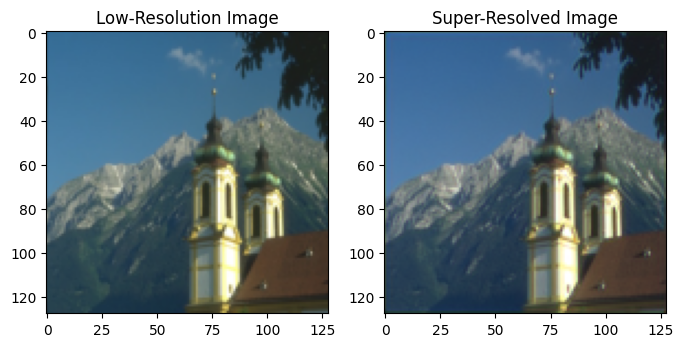

In [16]:
# Load a test image
test_image = Image.open("BSDS300/images/test/126007.jpg").convert("RGB")
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

test_image = transform(test_image).unsqueeze(0).to(device)

# Generate super-resolved image
generator.eval()
with torch.no_grad():
    sr_image = generator(test_image)

# Save and Display Results
save_image(sr_image, "sr_image.png")
save_image(test_image, "lr_image.png")

# Show images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Low-Resolution Image")
plt.imshow(np.transpose(test_image.squeeze().cpu().numpy(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.title("Super-Resolved Image")
plt.imshow(np.transpose(sr_image.squeeze().cpu().numpy(), (1, 2, 0)))
plt.show()

In [17]:
# Save the trained generator model
torch.save(generator.state_dict(), "generator.pth")
print("Generator model saved successfully!")


Generator model saved successfully!


In [18]:
# Load the saved generator model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator()
generator.load_state_dict(torch.load("generator.pth"))
generator.to(device)
generator.eval()
print("Generator model loaded successfully!")

Generator model loaded successfully!


/var/folders/jx/wgc4gs5n3g3gsh1lw4khhs580000gn/T/ipykernel_87050/821299587.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generato

In [19]:
def upscale_image(generator, lr_image, device):
    generator.eval()
    lr_image = lr_image.to(device)
    with torch.no_grad():
        sr_image = generator(lr_image)
    return sr_image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012981478..1.051173].


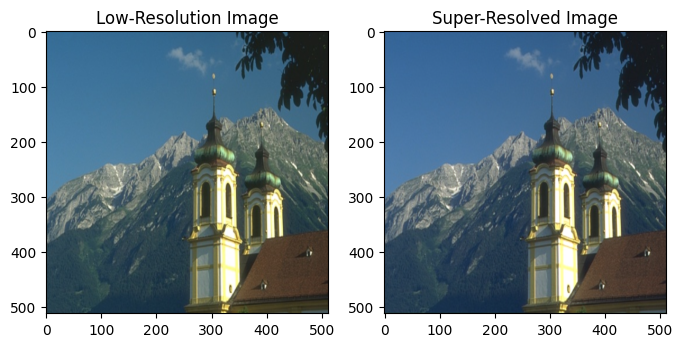

In [20]:
# Load a test image
test_image = Image.open("BSDS300/images/test/126007.jpg").convert("RGB")
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

test_image = transform(test_image).unsqueeze(0).to(device)

# Generate super-resolved image using the loaded model
sr_image = upscale_image(generator, test_image, device)

# Save and Display Results
save_image(sr_image, "sr_image.png")
save_image(test_image, "lr_image.png")

# Show images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Low-Resolution Image")
plt.imshow(np.transpose(test_image.squeeze().cpu().numpy(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.title("Super-Resolved Image")
plt.imshow(np.transpose(sr_image.squeeze().cpu().numpy(), (1, 2, 0)))
plt.show()
